<a 
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab9.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

# Lab 10: Deep Reinforcement Learning

## Objective

- Build DQN and PPO Deep RL algorithms
- Learn the difference between Q Learning and Policy Gradient techniques

## Deliverable

For this lab you will submit an ipython notebook via learning suite. This lab gives you a lot of code, and you should only need to modify two of the cells of this notebook. Feel free to download and modify this notebook or create your own. The below code is given for your convinience. You can modify any of the given code if you wish.

## Tips

Deep reinforcement learning is difficult. We provide hyperparameters, visualizations, and code for gathering experience, but require you to code up algorithms for training your networks. 

- Your networks should be able to demonstrate learning on cartpole within a minute of wall time.

- Understand what your the starter code is doing. This will help you with the *TODO* sections. The main code block is similar for the two algorithms with some small yet important differences.

- We provide hyperparameters for you to start with. Feel free to experiment with different values, but these worked for us.

- **Print dtypes and shapes** throughout your code to make sure your tensors look the way you expect.

- The DQN algorithm is significantly more unstable than PPO. Even with a correct implementation it may fail to learn every 1/10 times.

- Unfortunately visualizing your agent acting in the environment is non-trivial in Colab. You can visualize your agent by running this code locally and uncommenting the `env.render()` line.

## Grading

- 40% Part 1: DQN *TODO* methods
- 40% Part 2: PPO *TODO* methods
- 20% Cartpole learning curves


### Cartpole

Cartpole is a simple environment to get your agent up and running. It has a continuous state space of 4 dimensions and a discrete action space of 2. The agent is given a reward of 1 for each timestep it remains standing. Your agent should be able to reach close to 200 cumulative reward for an episode after a minute or two of training. The below graphs show example results for dqn (left) and ppo (right).

![alt text](https://drive.google.com/uc?export=view&id=1Bpz1jOPMF1zJMW6XBJJ44sJ-RmO_q6_U)
![alt text](https://drive.google.com/uc?export=view&id=1M1yygXhLKDL8qfRXn7fh_K-zq7-pQRhY)

### TODO

- Train DQN and PPO on cartpole
- Display learning curves with average episodic reward per epoch

# Starter Code

## Init

In [ ]:
! pip3 install gym
! pip3 install torch
####################
! pip install gym pyvirtualdisplay
! apt-get install -y xvfb python-opengl ffmpeg
####################

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,280 kB of archives.
After this operation, 7,687 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 1,280 kB in 2s (552 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 155332 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import chain
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np

####################
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
####################

In [ ]:
######################
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400,900))
display.start()
######################

In [ ]:
######################
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env
######################

## DQN

## Part 1


Deep Q-Network (https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) is a Q-learning algorithm that learns values for state-action pairs.

Actions are sampled according to an $\epsilon-greedy$ policy to help with exploration of the state space. Every time an action is sampled, the agent chooses a random action with $\epsilon$ probability. Otherwise, the agent selects the action with the highest Q-value for a state. $\epsilon$ decays over time according to $\epsilon \gets \epsilon * epsilon\_decay$.

Tuples of state, action, reward, next_state, and terminal $(s,a,r,s',d)$ are collected during training. Every $learn\_frequency$ steps $sample\_size$ tuples are sampled and made into 5 tensors tensors of states, actions, rewarads, next_states, and terminals.

The loss for a batch of size N is given below.

$Loss=\frac{1}{N}\sum \bigg(Q(s,a) - (r + \gamma \underset{a'\sim A}{max} \hat{Q}(s',a')(1-d))\bigg)^2 $

Where: 

- $Q(s,a)$ is the state-action pair for the current state and action.

- $r$ is the reward

- $\gamma$ is the discount factor

- $\underset{a'\sim A}{max} \hat Q(s',a')$ is the maximum choice for the future state-action pair for the target network (which is $\hat Q)$

- $(1-d)$ is to tell if the model is done or not. (If it is done, $d=1$ will be true, so we will only account for the current state-action pair $Q(s,a)$.)


Loss is calculated and used to update the Q-Network. The target network $\hat{Q}$ begins as a copy of the Q network but is not updated by the optimizer. Every $target\_update$ steps, the target network is updated with the parameters of the Q-Network. This process is a type of bootstrapping.

### TODO

- Implement get action method with e-greedy policy
- Implement sample batch method
- Implement DQN learning algorithm



In [ ]:
def get_action_dqn(network, state, epsilon, epsilon_decay):
  """Select action according to e-greedy policy and decay epsilon

    Args:
        network (QNetwork): Q-Network
        state (np-array): current state, size (state_size)
        epsilon (float): probability of choosing a random action
        epsilon_decay (float): amount by which to decay epsilon

    Returns:
        action (int): chosen action [0, action_size)
        epsilon (float): decayed epsilon
  """
  # Step 1: Turn the state from np.array to tensor and pass to gpu.
  tensor_state = torch.from_numpy(state.astype('float32')).cuda()

  # Step 2: Get a random number to see if we choose random step or not.
  random_chance = np.random.random()

  # Step 3.0: If we choose random step, get the q-values from that
  if random_chance <= epsilon:
    # Note: we have np.random.random_sample((2,)) because there are only two actions for our cartpole environment.
      # So np.random.random_sample((2,)) will return two random 'probabilities.'
    next_choice = torch.from_numpy(np.random.random_sample((2,)).astype('float32'))

  # Step 3.1: If we do not choose a random step, plug the tensor_state into the network to get the best choice from q-table. 
    # Note: Make sure to unsqueeze because we need a 'batch.'
  elif random_chance > epsilon:
    next_choice = network(tensor_state.unsqueeze(0))
  
  # Step 4: Take the argmax of next_choice to get the actual choice we will take.
  final_choice = torch.argmax(next_choice)

  # Step 5: Calculate the new epsilon with its decay
  new_epsilon = epsilon*epsilon_decay
  return final_choice.item(), new_epsilon


def prepare_batch(memory, batch_size):
  """Randomly sample batch from memory
     Prepare cuda tensors

    Args:
        memory (list): state, action, next_state, reward, done tuples
        batch_size (int): amount of memory to sample into a batch

    Returns:
        state (tensor): float cuda tensor of size (batch_size x state_size)
          This is size (32 x 4)
        action (tensor): long tensor of size (batch_size)
          This is size (32) because there are 32 opportunities to take actions.
        next_state (tensor): float cuda tensor of size (batch_size x state_size)
          This is size (32 x 4)
        reward (tensor): float cuda tensor of size (batch_size)
          This is size (32)
        done (tensor): float cuda tensor of size (batch_size)
          This is size (32)
  """
  # state_size = 4
  # batch_size = 32
  # random_sample_batch is a list of size 32 that is one of the elements of the memory list (non-repeating).
  random_sample_batch = random.sample(memory, batch_size)

  # Get necessary tensors
  state      = [item[0] for item in random_sample_batch]
  action     = [item[1] for item in random_sample_batch]
  next_state = [item[2] for item in random_sample_batch]
  reward     = [item[3] for item in random_sample_batch]
  done       = [item[4] for item in random_sample_batch]
  #print(f"done {done}\n")
  #print(f"done as int {done.int()}")

  # Turn those tensors into the needed tensors as perscribed above.
  state_t      = torch.FloatTensor(state).cuda()
  action_t     = torch.LongTensor(action).cuda()
  next_state_t = torch.FloatTensor(next_state).cuda()
  reward_t     = torch.FloatTensor(reward).cuda()
  done_t       = torch.FloatTensor(done).cuda()

  return state_t, action_t, next_state_t, reward_t, done_t

  
def learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update):
  """Update Q-Network according to DQN Loss function
     Update Target Network every target_update global steps

    Args:
        batch (tuple): tuple of state, action, next_state, reward, and done tensors
        optim (Adam): Q-Network optimizer
        q_network (QNetwork): Q-Network
        target_network (QNetwork): Target Q-Network
        gamma (float): discount factor
        global_step (int): total steps taken in environment
        target_update (int): frequency of target network update
  """
  # Step 1: Separate tuple
  state, action, next_state, reward, done_tensor = batch

  # Step 2: Clear gradients.
  optim.zero_grad()

  # Step 3: Get y_truth from the target_network (pass in next_state to get prediction)
  y_truth = target_network(next_state)  # This gives us a bunch of predicted values
  #print(f"y_truth.shape\t\t\t {y_truth.shape}\n")

  # Step 4: Get y_hat from the q_network
  y_hat = q_network(state)
  action_onehot = F.one_hot(action).bool()

  
  # Step 5: Get the reward + gamma*argmax(future)*(1-dones)
  second_half_of_equation = reward + (gamma * torch.max(y_truth, dim=1)[0] * (1-done_tensor.long()))

  # Step 5: Get loss
  loss = F.mse_loss(y_hat[action_onehot], second_half_of_equation)

  # Step 6: Do normal nn stuff
  loss.backward()
  optim.step()

  
  if global_step % target_update == 0:
    # Question: How do I update target network?
    target_network.load_state_dict(q_network.state_dict())  # ?
  pass



### Modules

In [ ]:
# Q-Value Network
class QNetwork(nn.Module):
  def __init__(self, state_size, action_size):
    super().__init__()
    hidden_size = 8
    
    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, action_size))  
    
  def forward(self, x):
    """Estimate q-values given state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          q-values (tensor): estimated q-values, size (batch x action_size)
    """
    return self.net(x)

### Main

In [ ]:
def dqn_main():
  # Hyper parameters
  lr = 1e-3
  epochs = 500
  start_training = 1000
  gamma = 0.99
  batch_size = 32
  epsilon = 1
  epsilon_decay = .9999
  target_update = 1000
  learn_frequency = 2

  # Init environment
  state_size = 4
  action_size = 2
  env = gym.make('CartPole-v1', )

  # Init networks
  q_network = QNetwork(state_size, action_size).cuda()
  target_network = QNetwork(state_size, action_size).cuda()
  target_network.load_state_dict(q_network.state_dict())

  # Init optimizer
  optim = torch.optim.Adam(q_network.parameters(), lr=lr)

  # Init replay buffer
  memory = []

  # Begin main loop
  results_dqn = []
  global_step = 0
  loop = tqdm(total=epochs, position=0, leave=False)
  for epoch in range(epochs):
    ######################
    last_epoch = (epoch+1 == epochs)
    # Record the last epoch, not the previous epochs
    if last_epoch:
      env = wrap_env(env)
    ######################

    # Reset environment
    state = env.reset()
    done = False
    cum_reward = 0  # Track cumulative reward per episode

    # Begin episode
    while not done and cum_reward < 200:  # End after 200 steps 
      # Select e-greedy action
      action, epsilon = get_action_dqn(q_network, state, epsilon, epsilon_decay)

      # Take step
      next_state, reward, done, _ = env.step(action)
      # env.render()

      # Store step in replay buffer
      memory.append((state, action, next_state, reward, done))

      cum_reward += reward
      global_step += 1  # Increment total steps
      state = next_state  # Set current state

      # If time to train
      if global_step > start_training and global_step % learn_frequency == 0:

        # Sample batch
        batch = prepare_batch(memory, batch_size)
        
        # Train
        learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update)
    ######################
    env.close()
    ######################
    # Print results at end of episode
    results_dqn.append(cum_reward)
    loop.update(1)
    loop.set_description('Episodes: {} Reward: {}'.format(epoch, cum_reward))
  
  return results_dqn

results_dqn = dqn_main()
######################
show_video()
######################

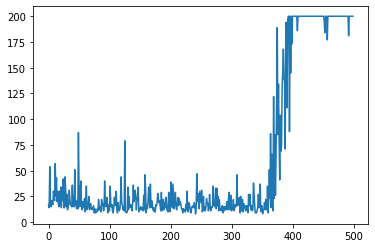

In [ ]:
plt.plot(results_dqn)
plt.show()

## PPO

## Part 2

Proximal Policy Optimization (https://arxiv.org/pdf/1707.06347.pdf) is a type of policy gradient method. Instead of calculating Q-values, we train a network $\pi$ to optimize the probability of taking good actions directly, using states as inputs and actions as outputs. PPO also uses a value network $V$ that estimates state values in order to estimate the advantage $\hat{A}$. 

Tuples of state, action distribution, action taken, and return $(s,\pi(s), a,\hat{R})$ are gathered for several rollouts. After training on this experience, these tuples are discarded and new experience is gathered.

Loss for the value network and the policy network are calculated according to the following formula:

$Loss=ValueLoss+PolicyLoss$

$ValueLoss=\frac{1}{N}\sum \bigg(\hat{R} - V(s) \bigg)^2 $

$PolicyLoss=-\frac{1}{N}\sum \min\bigg( \frac{\pi'(a|s)}{\pi(a|s)} \hat{A}, clip(\frac{\pi'(a|s)}{\pi(a|s)},1-\epsilon,1+\epsilon) \hat{A} \bigg) $

$\hat{R}_t = \sum_{i=t}^H \gamma^{i-1}r_i$

$\hat{A}_t=\hat{R}_t-V(s_t)$

Here, $\pi'(a|s)$ is the probability of taking an action given a state under the current policy and $\pi(a|s)$ is the probability of taking an action given a state under the policy used to gather data. In the loss function, $a$ is the action your agent actually took and is sampled from memory. 

Additionally, the $clip$ function clips the value of the first argument according to the lower and upper bounds in the second and third arguments resectively.

Another important note: Your the calculation of your advantage $\hat{A}$ should not permit gradient flow from your policy loss calculation. In other words, make sure to call `.detach()` on your advantage.

### TODO

- Implement calculate return method
- Implement get action method
- Implement PPO learning algorithm

In [ ]:
def calculate_return(memory, rollout, gamma):
  """Return memory with calculated return in experience tuple

    Args:
        memory (list): (state, action, action_dist, return) tuples
        rollout (list): (state, action, action_dist, reward) tuples from last rollout
        gamma (float): discount factor
          Gamma = 0.9

    Returns:
        list: memory updated with (state, action, action_dist, return) tuples from rollout
  """
  # Calculating the return.
    # All we are doing is appending what has happened in the rollout to past memory,
    # and calculating the true reward.
  calc_return = 0
  for state, action, action_dist, reward in reversed(rollout):
    calc_return = reward + calc_return*gamma
    memory.append((state, action, action_dist, calc_return))

  return memory


def get_action_ppo(network, state):
  """Sample action from the distribution obtained from the policy network

    Args:
        network (PolicyNetwork): Policy Network
        state (np-array): current state, size (state_size)
          State size = 4

    Returns:
        int: action sampled from output distribution of policy network
        array: output distribution of policy network
  """
  # with torch.no_grad() stops this stuff from wanting a gradient
    # (This was done to stop an error I was getting. Thanks, Connor!)
  with torch.no_grad():
    # Converting the current state from list to Float32 tensor and putting it on the GPU.
    state_t = torch.from_numpy(state.astype('float32')).cuda()

    # Sampling an action from the network based on the current state.
    sample_action = network(state_t.unsqueeze(0))  # Distribution

    # Chosing an action from the sample_action distribution,
      # torch.multinomial(sample_action, 1) will sample one action from the sample action distribution.
    chosen_action = torch.multinomial(sample_action, 1)

  return chosen_action.item(), sample_action


def learn_ppo(optim, policy, value, memory_dataloader, epsilon, policy_epochs):
  """Implement PPO policy and value network updates. Iterate over your entire 
     memory the number of times indicated by policy_epochs (policy_epochs = 5).    

    Args:
        optim (Adam): value and policy optimizer
        policy (PolicyNetwork): Policy Network
          policy_network = PolicyNetwork(state_size, action_size).cuda()
        value (ValueNetwork): Value Network
          value_network = ValueNetwork(state_size).cuda()
        memory_dataloader (DataLoader): dataloader with (state, action, action_dist, return) tensors
        epsilon (float): trust region
        policy_epochs (int): number of times to iterate over all memory
  """
  # Go through all epochs
  for epoch in range(policy_epochs):
    for batch in memory_dataloader:
      optim.zero_grad()
      
      # Get the all variables from memory (by batch)
      state, action, action_dist, return_v = batch

      # Convert each of the above variables into their appropriate dtype and putting them on the GPU
      state_t       = state.type(torch.FloatTensor).cuda()
      action_t      = action.type(torch.LongTensor).cuda()
      action_dist_t = action_dist.type(torch.FloatTensor).cuda()
      return_v_t    = return_v.type(torch.FloatTensor).cuda()

      # Calculate advantage Â
      advantage = (return_v_t - value(state_t).cuda()).detach()

      # Calculate value loss
      value_loss = F.mse_loss(return_v_t, value(state_t).squeeze())

      # Calculate π(s,a)
      policy_norm       = action_dist.squeeze(1)
      action_onehot     = F.one_hot(action).bool()
      taken_policy_norm = policy_norm[action_onehot]
      
      #Calculate π'(s,a)
      policy_prime       = policy(state_t)
      taken_policy_prime = policy_prime[action_onehot]
      
      #Calculate the ratio between π'(s,a)/π(s,a)
      prim_div_norm = taken_policy_prime / taken_policy_norm

      # Clipping π'(s,a)/π(s,a)
      clip = torch.clip(prim_div_norm, 1-epsilon, 1+epsilon)
      
      # Left part of the policy loss (π'(s,a)/π(s,a))*Â
      left_part = prim_div_norm * advantage

      # Right part of the policy loss clip*Â
      right_part = clip * advantage

      # Calculating policy loss
      policy_loss = torch.mean(torch.min(left_part, right_part))

      # Total loss
      total_loss = value_loss - policy_loss
      
      total_loss.backward()
      optim.step()



    # Go through entire dataset
      # Do everything else

  

### Modules

In [ ]:
# Dataset that wraps memory for a dataloader
class RLDataset(Dataset):
  def __init__(self, data):
    super().__init__()
    self.data = []
    for d in data:
      self.data.append(d)
  
  def __getitem__(self, index):
    return self.data[index]
 
  def __len__(self):
    return len(self.data)


# Policy Network
class PolicyNetwork(nn.Module):
  def __init__(self, state_size, action_size):
    super().__init__()
    hidden_size = 8
    
    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, action_size),
                             nn.Softmax(dim=1))
  
  def forward(self, x):
    """Get policy from state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          action_dist (tensor): probability distribution over actions (batch x action_size)
    """
    return self.net(x)
  

# Value Network
class ValueNetwork(nn.Module):
  def __init__(self, state_size):
    super().__init__()
    hidden_size = 8
  
    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, 1))
    
  def forward(self, x):
    """Estimate value given state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          value (tensor): estimated value, size (batch)
    """
    return self.net(x)

### Main

In [ ]:
def ppo_main():
  # Hyper parameters
  lr = 1e-3
  epochs = 20
  env_samples = 100
  gamma = 0.9
  batch_size = 256
  epsilon = 0.2
  policy_epochs = 5

  # Init environment 
  state_size = 4
  action_size = 2
  env = gym.make('CartPole-v1')

  # Init networks
  policy_network = PolicyNetwork(state_size, action_size).cuda()
  value_network = ValueNetwork(state_size).cuda()

  # Init optimizer
  optim = torch.optim.Adam(chain(policy_network.parameters(), value_network.parameters()), lr=lr)

  # Start main loop
  results_ppo = []
  loop = tqdm(total=epochs, position=0, leave=False)
  for epoch in range(epochs):
    ######################
    last_epoch = (epoch+1 == epochs)
    # Record only last epoch
    if last_epoch:
      env = wrap_env(env)
    ######################
    
    memory = []  # Reset memory every epoch
    rewards = []  # Calculate average episodic reward per epoch

    # Begin experience loop
    for episode in range(env_samples):
      
      # Reset environment
      state = env.reset()
      done = False
      rollout = []
      cum_reward = 0  # Track cumulative reward

      # Begin episode
      while not done and cum_reward < 200:  # End after 200 steps   
        # Get action
        action, action_dist = get_action_ppo(policy_network, state)
        
        # Take step
        next_state, reward, done, _ = env.step(action)
        # env.render()

        # Store step
        rollout.append((state, action, action_dist, reward))

        cum_reward += reward
        state = next_state  # Set current state

      # Calculate returns and add episode to memory
      memory = calculate_return(memory, rollout, gamma)

      rewards.append(cum_reward)
      ######################
      env.close()
      ######################
    # Train
    dataset = RLDataset(memory)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    learn_ppo(optim, policy_network, value_network, loader, epsilon, policy_epochs)
    
    # Print results
    results_ppo.extend(rewards)  # Store rewards for this epoch
    loop.update(1)
    loop.set_description("Epochs: {} Reward: {}".format(epoch, results_ppo[-1]))

  return results_ppo

results_ppo = ppo_main()
######################
show_video()
######################

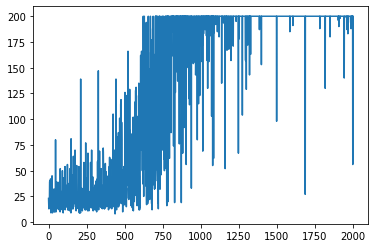

In [ ]:
plt.plot(results_ppo)
plt.show()

In [ ]:
!python -V

Python 3.7.12
